# eBPF Library Usage

This notebook investigates eBPF library usage using data pulled from [Sourcegraph](sourcegraph.com)

## Dataset

First let us scrape the necessary data from Sourcegraph

In [141]:
import getpass
SOURCEGRAPH_TOKEN = getpass.getpass("SOURCEGRAPH_API_TOKEN")

SOURCEGRAPH_API_TOKEN ········


In [142]:
import json
import urllib.parse
import requests

headers = {'Authorization': 'token {}'.format(SOURCEGRAPH_TOKEN)}

def repos_by_library(library, language, query):
    graphql = """
    query ($query: String!) {
      site {
        buildVersion
      }
      search(query: $query) {
        results {
          results {
            __typename
            ... on FileMatch {
              repository {
                name
                url
              }
            }
          }
          limitHit
          cloning {
            name
          }
          missing {
            name
          }
          timedout {
            name
          }
          resultCount
          elapsedMilliseconds
          ...SearchResultsAlertFields
        }
      }
    }

    fragment SearchResultsAlertFields on SearchResults {
      alert {
        title
        description
        proposedQueries {
          description
          query
        }
      }
    }
    """
    payload = { 'query': graphql, 'variables': { 'query': query } }
    r = requests.post('https://sourcegraph.com/.api/graphql', json=payload, headers=headers)
    results = json.loads(r.text)
    repos = {}
    for r in results["data"]["search"]["results"]["results"]:
        if r["repository"]["name"] not in repos:
            r = r["repository"]
            r["library"] = library
            r["language"] = language
            r["stars"] = get_stars(r["name"])
            repos[r["name"]] = r
    return repos

def get_stars(repo):
    graphql = """
    query GetStars($repoName: String!) {
      repository(name: $repoName) {
        stars
      }
    }
    """
    payload = { 'query': graphql, 'variables': { 'repoName': repo } }
    r = requests.post('https://sourcegraph.com/.api/graphql', json=payload, headers=headers)
    results = json.loads(r.text)
    return results["data"]["repository"]["stars"]

repos = {}

print("Getting libbpf stats")
libbpf_repos = repos_by_library('libbpf', 'C', '#include <bpf/libbpf.h> lang:c fork:no -repohasfile:Kbuild count:4000')
repos.update(libbpf_repos)

print("Getting cilium stats")
cilium_repos = repos_by_library('ebpf', 'Go', 'github.com/cilium/ebpf lang:go fork:no count:4000')
repos.update(cilium_repos)

print("Getting libbpfgo stats")
libbpfgo_repos = repos_by_library('libbpfgo', 'Go', 'github.com/aquasecurity/libbpfgo lang:go fork:no count:4000')
repos.update(libbpfgo_repos)

print("Getting aya stats")
aya_repos = repos_by_library('aya', 'Rust', 'file:Cargo.toml fork:no -repo:"aya-rs" content:"aya =" OR content:"dependencies.aya"')
repos.update(aya_repos)

print("Getting redbpf stats")
redbpf_repos = repos_by_library('redbpf', 'Rust', 'file:Cargo.toml fork:no -repo:"redbpf" content:"redbpf =" OR content:"dependencies.redbpf"')
repos.update(redbpf_repos)

print("Getting libbpf_rs stats")
libbpf_rs_repos = repos_by_library('libbpf-rs', 'Rust', 'file:Cargo.toml fork:no -repo:"libbpf" content:"libbpf-rs =" OR content:"dependencies.libbpf-rs"')
repos.update(libbpf_rs_repos)

Getting libbpf stats
Getting cilium stats
Getting libbpfgo stats
Getting aya stats
Getting redbpf stats
Getting libbpf_rs stats


## Analysis

### eBPF Library Usage

This plot looks at the overall distribution of library usage across all projects.

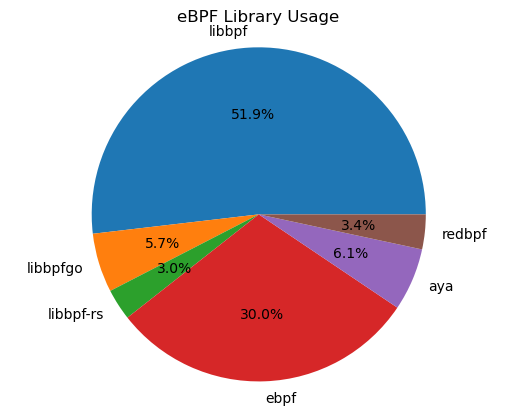

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline

sizes = [len(libbpf_repos), len(libbpfgo_repos), len(libbpf_rs_repos), len(cilium_repos), len(aya_repos), len(redbpf_repos)]
labels = 'libbpf', 'libbpfgo', 'libbpf-rs', 'ebpf', 'aya', 'redbpf'

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('eBPF Library Usage')
plt.axis('equal')

plt.show()

### eBPF Library Usage (Weighted by popularity)

This plot weights the distribution of libraries using "Github Stars".
This should give a more accurate impression of which libraries are popular since it will de-prioritize the many small sample/demo repositories in the dataset.

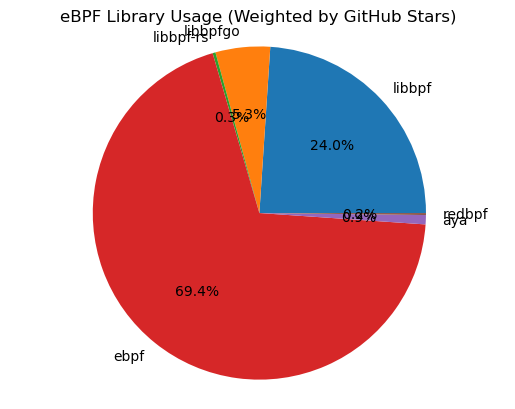

In [144]:
import matplotlib.pyplot as plt
%matplotlib inline

libbpf_repos = { k: v['stars'] for k,v in repos.items() if v['library'] == "libbpf" }
cilium_repos = { k: v['stars'] for k,v in repos.items() if v['library'] == "ebpf" }
libbpfgo_repos = { k: v['stars'] for k,v in repos.items() if v['library'] == "libbpfgo" }
aya_repos = { k: v['stars'] for k,v in repos.items() if v['library'] == "aya" }
redbpf_repos = { k: v['stars'] for k,v in repos.items() if v['library'] == "redbpf" }
libbpf_rs_repos = { k: v['stars'] for k,v in repos.items() if v['library'] == "libbpf-rs" }

sizes = [sum(libbpf_repos.values()), sum(libbpfgo_repos.values()), sum(libbpf_rs_repos.values()), sum(cilium_repos.values()), sum(aya_repos.values()), sum(redbpf_repos.values())]
labels = 'libbpf', 'libbpfgo', 'libbpf-rs', 'ebpf', 'aya', 'redbpf'

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('eBPF Library Usage (Weighted by GitHub Stars)')
plt.axis('equal')

plt.show()

### Most popular projects using eBPF libraries

In [145]:
from collections import OrderedDict
import pandas as pd

top_20 = OrderedDict(sorted(repos.items(), key=lambda v: v[1]['stars'], reverse=True)[0:20])
pd.DataFrame(data=top_20.values(), columns=["name", "library", "stars"])

,name,library,stars
0,github.com/kubernetes/kubernetes,ebpf,91583
1,github.com/moby/moby,ebpf,63908
2,github.com/netdata/netdata,libbpf,60447
3,github.com/go-delve/delve,ebpf,19093
4,github.com/google/gvisor,ebpf,12998
5,github.com/cilium/cilium,ebpf,12828
6,github.com/gravitational/teleport,libbpfgo,12467
7,github.com/containerd/containerd,ebpf,11927
8,github.com/GoogleContainerTools/kaniko,ebpf,10889
9,github.com/systemd/systemd,libbpf,9975
